# Introduction
In this notebook I would like to take a closer look at quartiles of energy presented in frequency domain.
The main focus is to look the difference when just performing FFT and do some further processing after FFT.
We will start defining a signal, which contains many(defined by user) frequencies with random amplitude and shift of phase.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Parameters

In [2]:
time_seconds = 10 # in seconds
frequency_sampling = 100 # in Hertz
number_of_frequencies = 100
max_freq = 39.9
max_amplitude = 2

In [3]:
assert (frequency_sampling > (max_freq*2)), "Nyquist isn't be happy"

## Generating signals

In [4]:
time = np.arange(0, time_seconds, 1/frequency_sampling)
phase = np.round(np.random.rand(number_of_frequencies)*2*np.pi,1)
freq = np.round(np.random.rand(number_of_frequencies)*max_freq,1)
amp = np.round(np.random.rand(number_of_frequencies)*max_amplitude,1)
signals = np.cos(2*np.pi*np.outer(freq,time)+phase[:,np.newaxis]) * amp[:, None]
signal = np.sum(signals,0)

### Plotting each one and sum
or there are to many plots so it will plot only first 10

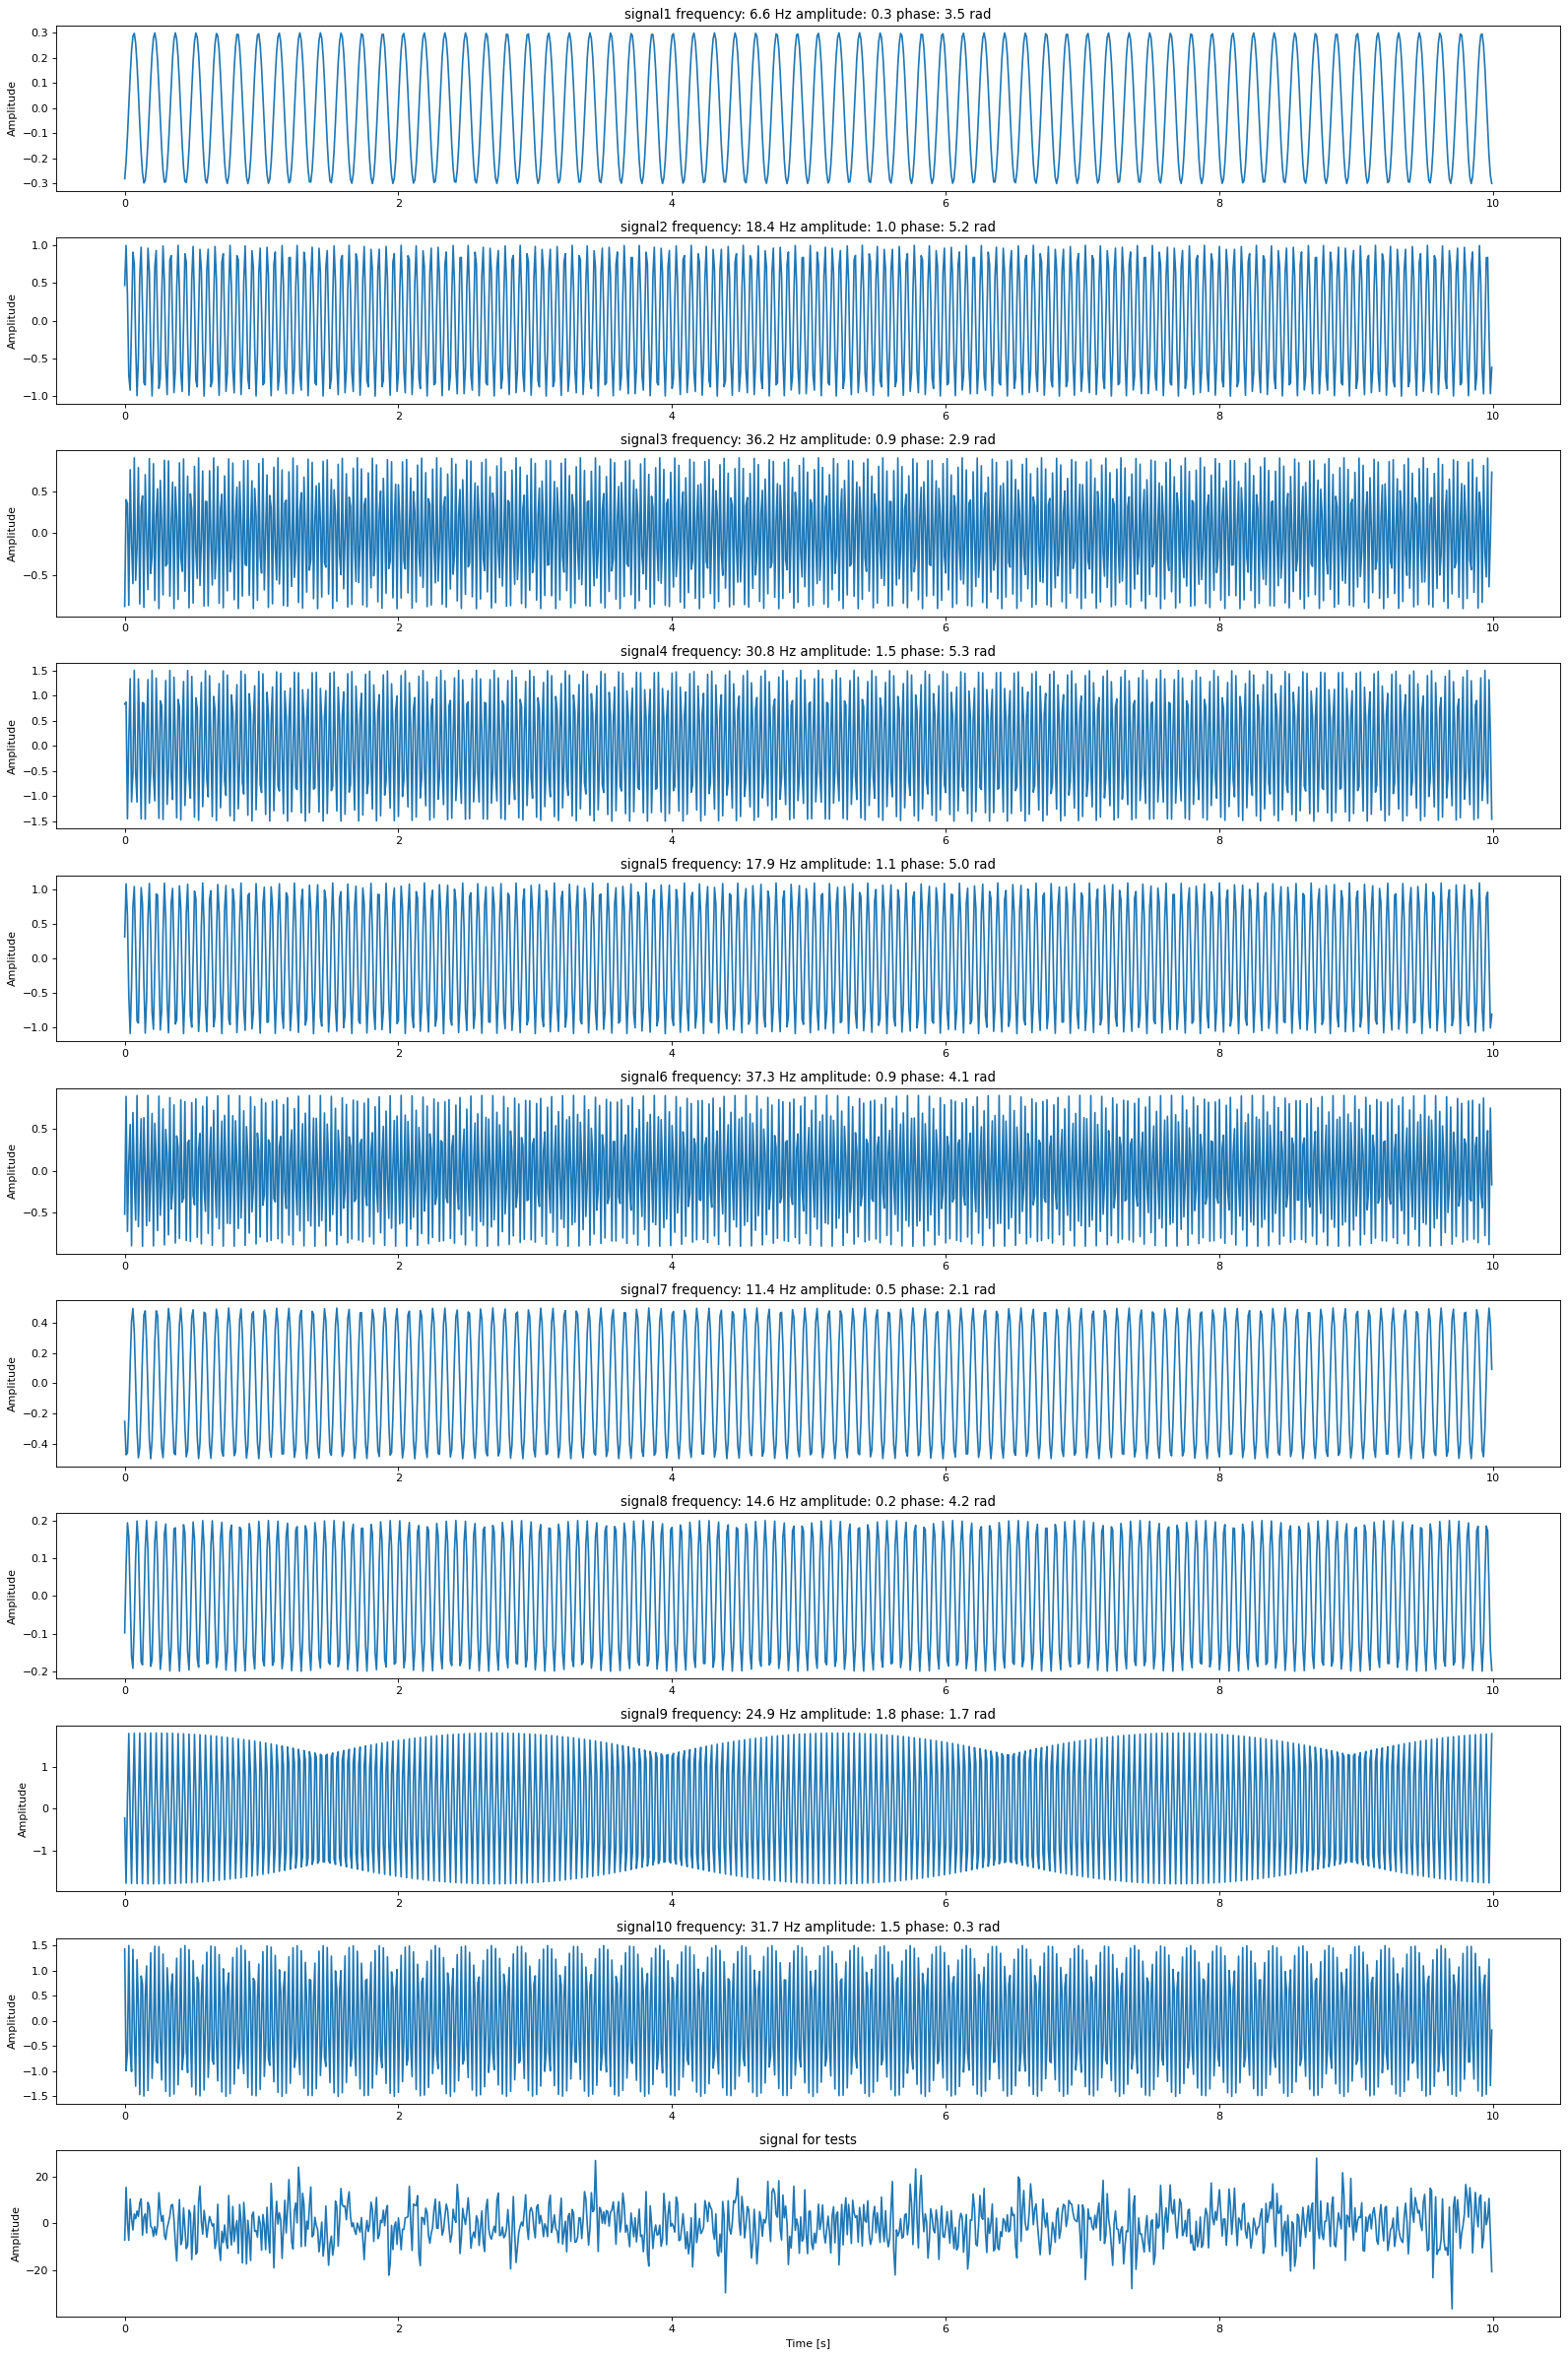

In [16]:
temp_N = min([number_of_frequencies,10])
plt.figure(figsize=(20, 3*temp_N), dpi=80)
for i in range(temp_N):
    plt.subplot(temp_N+1,1,i+1)
    plt.plot(time, signals[i,:])
    plt.title(f"signal{i+1} frequency: {freq[i]} Hz amplitude: {amp[i]} phase: {phase[i]} rad")
    plt.ylabel("Amplitude")
else:
    plt.subplot(temp_N+1,1,temp_N+1)
    plt.plot(time, signal)
    plt.title(f"signal for tests")
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    plt.tight_layout()

# FFT functions

## common approach

In [9]:
def commonFFT(signal, Fs):
    N = len(signal)
    frequency_vector = np.arange(0, Fs, Fs/N)
    return frequency_vector, np.abs(np.fft.fft(signal))/N

## modified

In [10]:
def modifiedFFT(signal, Fs):
    N = len(signal)
    frequency_vector = np.arange(0, Fs, Fs/N)
    com_fft = np.abs(np.fft.fft(signal))/N
    com_fft[1:int(np.ceil(N/2)+1)] = com_fft[1:int(np.ceil(N/2)+1)]*2
    com_fft[int(np.ceil(N/2)+1):].fill(0)
    return frequency_vector, com_fft

Calcucalating those FFTs

In [11]:
fvec_common, abs_fft_common = commonFFT(signal, Fs=frequency_sampling)
fvec_modified, abs_fft_modified = modifiedFFT(signal, Fs=frequency_sampling)

Text(0.5, 0, 'Frquency [Hz]')

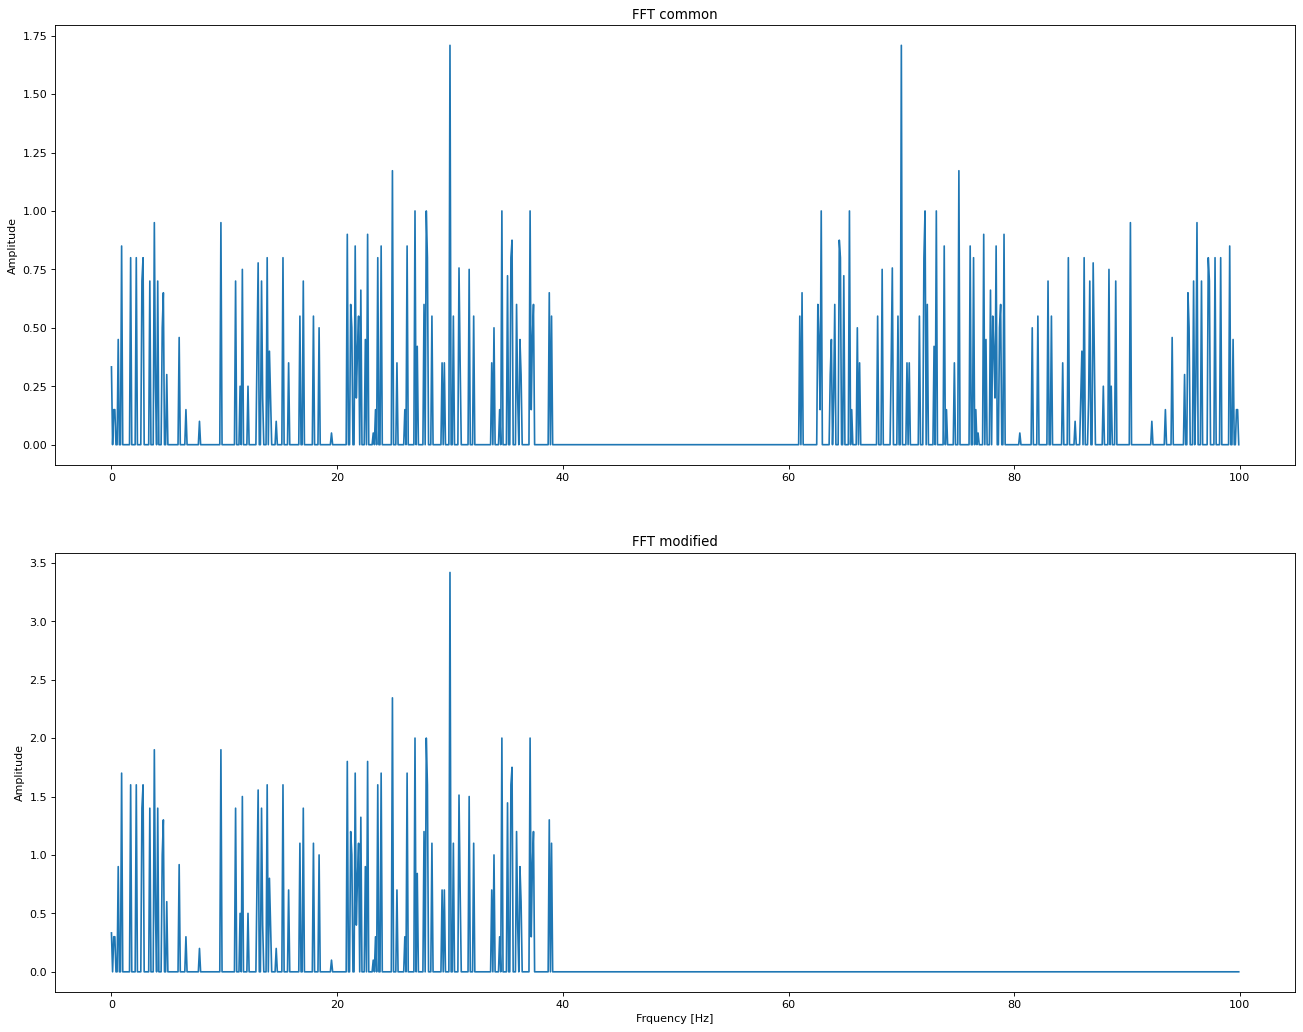

In [15]:
plt.figure(figsize=(20, 16), dpi=80)
plt.subplot(2,1,1)
plt.plot(fvec_common, abs_fft_common)
plt.title(f"FFT common")
plt.ylabel("Amplitude")
plt.subplot(2,1,2)
plt.plot(fvec_modified, abs_fft_modified)
plt.title(f"FFT modified")
plt.ylabel("Amplitude")
plt.xlabel("Frquency [Hz]")

# Short summary:
1. We see the amplitudes on modified reflects the one set in the beginning of the scripts, but amplitudes on the common FFT equals the half of expected amplitude
2. We see significant part of modified FFT is set to zero, it is we pushed those amplitudes to range (0;Fs/2]
3. We see common FFT plot has line of symmetry at point Fs/2

# Quartiles of frequency

In [13]:
def quartiles_fft(abs_fft, fvec):
    cum_energy = np.cumsum(abs_fft**2)
    total_energy = cum_energy[-1]
    q1 = min(fvec[cum_energy>(total_energy*1/4)])
    q2 = min(fvec[cum_energy>(total_energy*2/4)])
    q3 = min(fvec[cum_energy>(total_energy*3/4)])
    return q1, q2, q3

Using the observations made on the FFT common assuming zero amplitude at f=0
1. Knowing that the point Fs/2 is the line of symmetry there will also be Q2. However, considering the frequency range it will be the highest frequency component from the beginning of the script not exceeding this value. Differences may be present due to the phenomenon of spectral leakage.
2. Having determined Q1 and being aware of the reflection of amplitudes, Q3 can be determined from the formula: Q3= Fs - Q1
In ordrer to show it the cell below shows Quartiles basing on common FFT approach, then for comparison Quartiles for modified FFT and at last spot Q2 and Q3 will be calculated as described above.

In [14]:
q1_common, q2_common, q3_common = quartiles_fft(abs_fft_common, fvec_common)
print(f"""Using common FFT:
Q1: {q1_common} Hz
Q2: {q2_common} Hz
Q3: {q3_common} Hz""")
q1_modified, q2_modified, q3_modified = quartiles_fft(abs_fft_modified, fvec_modified)
print(f"""Using modified FFT:
Q1: {q1_modified} Hz
Q2: {q2_modified} Hz
Q3: {q3_modified} Hz""")
var1 = q1_common
var2 = max_freq
var3 = frequency_sampling - var1
print(f"""Trying to predict:
Q1 from common: {var1} Hz
Q2 predefined: {var2} Hz
Q3 from Q1 and FS: {var3} Hz
      """)

Using common FFT:
Q1: 23.900000000000002 Hz
Q2: 39.0 Hz
Q3: 76.10000000000001 Hz
Using modified FFT:
Q1: 13.0 Hz
Q2: 23.900000000000002 Hz
Q3: 30.0 Hz
Trying to predict:
Q1 from common: 23.900000000000002 Hz
Q2 predefined: 39.9 Hz
Q3 from Q1 and FS: 76.1 Hz
      


Why it is so?
It comes from fourier transform, the FFT returns it for range [0;Fs) and when not taking f=0Hz into consideration in terms of amplitude we have a line of symmetry at Fs/2 so in other words, the same amplitudes appear on the left and right side are the same, so the energy is also the same.
Moreover, due to this symmetry line at Fs/2 when zero amplitude at f=0Hz is observed the sequence of frequnecy in range (0;Q1] is the same as reverse order in range [Q3;Fs)

# conclusion
features provided by proper signal processing may give much more informations even if in on first glance the results should be the same